In [20]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [10]:
df = pd.read_csv("train.csv")


## Data Sample

In [11]:
print(f"Total rows in train.csv: {len(df):,}")
print("Sample row:")
print(df.head(1))

Total rows in train.csv: 404,290
Sample row:
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  


## Skip duplicates data

In [42]:
# Extract unique questions only (skip duplicates where is_duplicate=1)
print("\nExtracting unique questions (filtering out duplicates)...")


df_unique = df[df['is_duplicate'] == 0].copy()
print(f"Filtered from {len(df):,} to {len(df_unique):,} non-duplicate pairs")


id_to_text = {}

for _, row in tqdm(df_unique.iterrows(), total=len(df_unique)):
    if pd.notna(row['question1']):
        id_to_text[str(row['qid1'])] = row['question1']
    if pd.notna(row['question2']):
        id_to_text[str(row['qid2'])] = row['question2']

# Remove any remaining duplicate texts while preserving order
texts = list(dict.fromkeys(id_to_text.values()))

print(f"\nLoaded {len(texts):,} unique questions")
print("Sample questions:")
for i in range(min(5, len(texts))):
    print(f"  {i+1}. {texts[i]}")


Extracting unique questions (filtering out duplicates)...
Filtered from 404,290 to 255,027 non-duplicate pairs


100%|██████████| 255027/255027 [00:12<00:00, 19828.54it/s]


Loaded 412,679 unique questions
Sample questions:
  1. What is the step by step guide to invest in share market in india?
  2. What is the step by step guide to invest in share market?
  3. What is the story of Kohinoor (Koh-i-Noor) Diamond?
  4. What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
  5. How can I increase the speed of my internet connection while using a VPN?


## Calc dataset embeddings

In [18]:
EMBEDDINGS_FILE = "quora_embeddings.npy"
TEXTS_FILE = "quora_texts.txt"

emb_model = SentenceTransformer('all-MiniLM-L6-v2')

if os.path.exists(EMBEDDINGS_FILE):
    print(f"\nLoading precomputed embeddings from {EMBEDDINGS_FILE}...")
    embeddings = np.load(EMBEDDINGS_FILE)
    print(f"Loaded embeddings with shape: {embeddings.shape}")
else:
    print("\nComputing embeddings ")
    embeddings = emb_model.encode(
        texts,
        batch_size=128,  # Larger batch size for Colab GPU
        show_progress_bar=True,
        normalize_embeddings=True
    )
    np.save(EMBEDDINGS_FILE, embeddings)
    print(f"Saved embeddings to {EMBEDDINGS_FILE} ({embeddings.shape})")



Computing embeddings 


Batches:   0%|          | 0/3225 [00:00<?, ?it/s]

Saved embeddings to quora_embeddings.npy ((412679, 384))


## define knn model and index dataset emdeddings

In [35]:
knn_model = NearestNeighbors(
    n_neighbors=50,  # Pre-compute up to 50 neighbors
    algorithm='auto',  # Let sklearn choose the best algorithm
    metric='euclidean',
    n_jobs=-1  # Use all CPU cores
)
knn_model.fit(embeddings)
print("KNN index built successfully!")


KNN index built successfully!


## calc query embeddings

In [32]:
def semantic_search(query: str, k: int = 10):
  query_embedding = emb_model.encode([query], normalize_embeddings=False)
  distances, indices = knn_model.kneighbors(query_embedding, n_neighbors=k)

  for idx, (doc_idx, distance) in enumerate(zip(indices[0], distances[0]), 1):
        print(f"{idx:2}. [Distance: {distance:.4f}] {texts[doc_idx]}")



## Now try it!

In [41]:
semantic_search("egypt")

 1. [Distance: 0.8065] What's the best story about Egypt?
 2. [Distance: 0.8201] What are interesting facts about Egypt?
 3. [Distance: 0.8260] What are some interesting facts about Egypt?
 4. [Distance: 0.8265] How do I leave Egypt?
 5. [Distance: 0.8320] What are the contemporary connections between Africa and Egypt?
 6. [Distance: 0.8355] What would be interesting for foreigners to know about Egypt?
 7. [Distance: 0.8425] What does the name "Egypt" mean? Where does it originate?
 8. [Distance: 0.8431] What comes to your mind when you hear the word Egypt?
 9. [Distance: 0.8509] If you have visited Egypt before, what is the thing that you liked most there?
10. [Distance: 0.8601] How was Egypt colonized?


## Benchmark script (generated)

SEMANTIC SEARCH ENGINE BENCHMARK

📊 DATASET STATISTICS
--------------------------------------------------------------------------------
Total unique questions: 412,679
Embedding dimension: 384
Total embeddings size: 604.51 MB
Average question length: 62.9 characters

⚡ QUERY LATENCY BENCHMARK
--------------------------------------------------------------------------------

Running queries...


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]



📈 Query Performance (n=10 queries):
  Total query time:
    Mean: 262.24 ms
    Median: 265.77 ms
    Min: 221.43 ms
    Max: 308.97 ms
    Std Dev: 33.06 ms

  Encoding time (GPU):
    Mean: 9.52 ms
    Median: 9.15 ms

  KNN search time (CPU):
    Mean: 252.72 ms
    Median: 257.01 ms

  Queries per second: 3.81 QPS

🚀 THROUGHPUT BENCHMARK (Batch Processing)
--------------------------------------------------------------------------------
  Batch size   1: 0.291s total, 3.44 QPS, 290.87 ms/query
  Batch size  10: 0.572s total, 17.48 QPS, 57.21 ms/query
  Batch size  50: 0.929s total, 53.83 QPS, 18.58 ms/query
  Batch size 100: 1.151s total, 86.88 QPS, 11.51 ms/query

📏 SCALABILITY TEST (Different K Values)
--------------------------------------------------------------------------------
  k=  1: 215.162 ms
  k=  5: 211.701 ms
  k= 10: 212.633 ms
  k= 20: 220.390 ms
  k= 50: 287.933 ms
  k=100: 214.912 ms

🎯 SEARCH QUALITY METRICS
-------------------------------------------------------

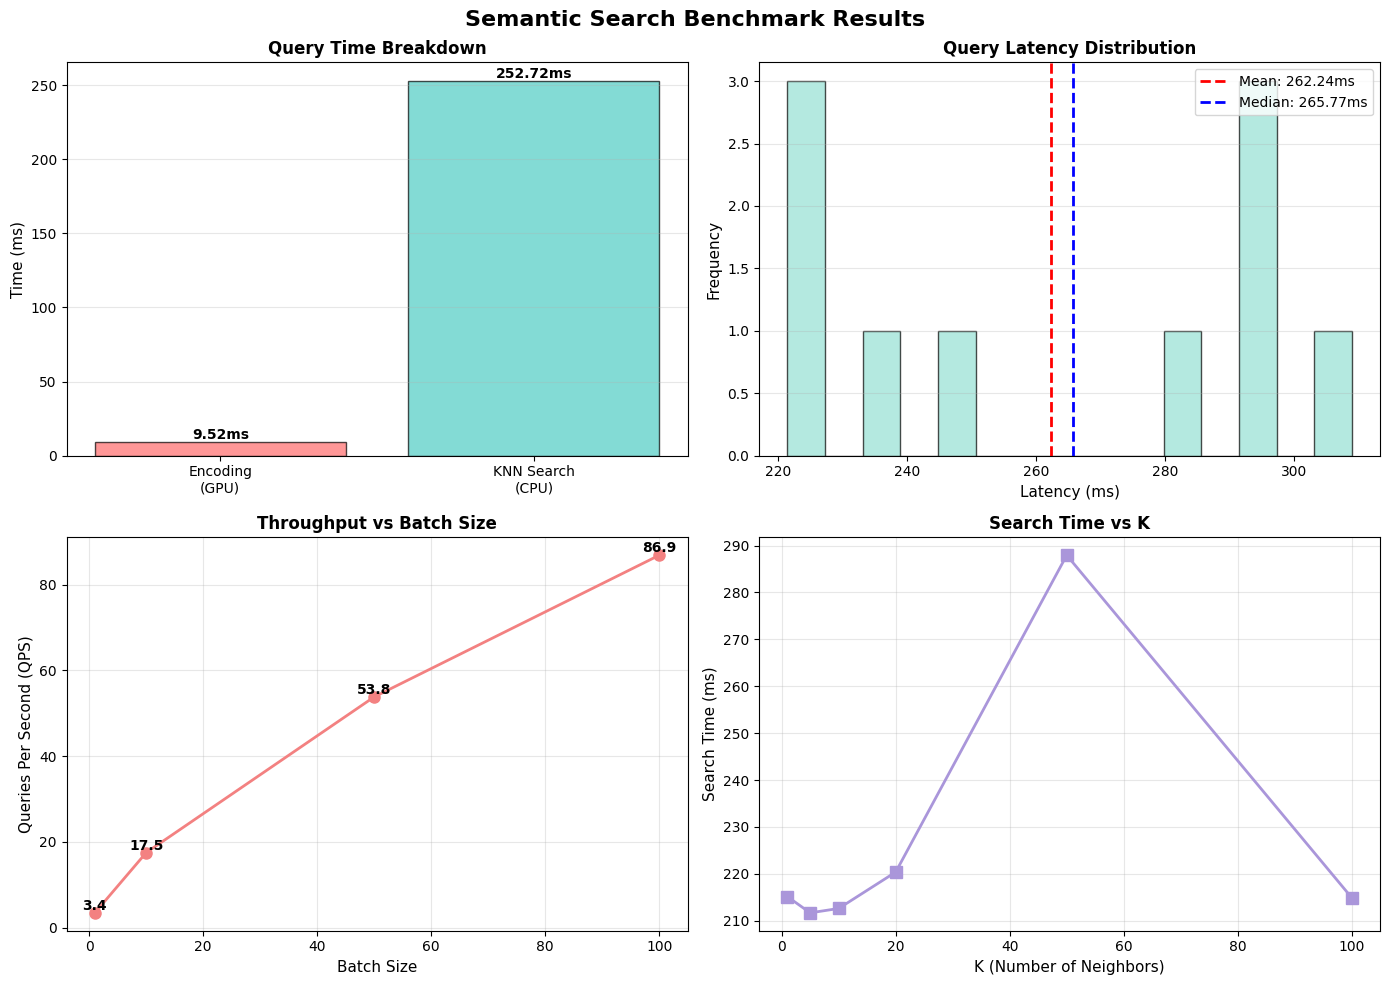


📋 BENCHMARK SUMMARY REPORT
              Metric       Value
     Total Questions     412,679
 Embedding Dimension         384
   Avg Query Latency   262.24 ms
Median Query Latency   265.77 ms
  Queries Per Second    3.81 QPS
 Encoding Time (GPU)     9.52 ms
   Search Time (CPU)   252.72 ms
  Total Memory Usage ~1329.92 MB
              Device   CPU + GPU

✅ BENCHMARK COMPLETE!


In [39]:
# =============================================
# SEMANTIC SEARCH BENCHMARKING SUITE
# =============================================

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

print("="*80)
print("SEMANTIC SEARCH ENGINE BENCHMARK")
print("="*80)

# =============================================
# 1. DATASET STATISTICS
# =============================================
print("\n📊 DATASET STATISTICS")
print("-"*80)
print(f"Total unique questions: {len(texts):,}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Total embeddings size: {embeddings.nbytes / (1024**2):.2f} MB")
print(f"Average question length: {np.mean([len(q) for q in texts[:1000]]):.1f} characters")

# =============================================
# 2. QUERY LATENCY BENCHMARK
# =============================================
print("\n⚡ QUERY LATENCY BENCHMARK")
print("-"*80)

# Test queries
test_queries = [
    "How to learn machine learning?",
    "What is the meaning of life?",
    "Best programming language for beginners",
    "How to lose weight fast?",
    "What are the symptoms of COVID-19?",
    "How do I start a business?",
    "Best universities in USA",
    "How to improve memory?",
    "What is quantum computing?",
    "How to make money online?"
]

# Warm-up run (first query is always slower due to cache)
_ = knn_model.kneighbors(emb_model.encode([test_queries[0]], normalize_embeddings=False), n_neighbors=10)

# Benchmark queries
query_times = []
encoding_times = []
search_times = []

print("\nRunning queries...")
for query in tqdm(test_queries):
    # Time encoding
    start = time.time()
    query_embedding = emb_model.encode([query], normalize_embeddings=False)
    encoding_time = time.time() - start
    encoding_times.append(encoding_time)

    # Time KNN search
    start = time.time()
    distances, indices = knn_model.kneighbors(query_embedding, n_neighbors=10)
    search_time = time.time() - start
    search_times.append(search_time)

    total_time = encoding_time + search_time
    query_times.append(total_time)

# Calculate statistics
print(f"\n📈 Query Performance (n={len(test_queries)} queries):")
print(f"  Total query time:")
print(f"    Mean: {np.mean(query_times)*1000:.2f} ms")
print(f"    Median: {np.median(query_times)*1000:.2f} ms")
print(f"    Min: {np.min(query_times)*1000:.2f} ms")
print(f"    Max: {np.max(query_times)*1000:.2f} ms")
print(f"    Std Dev: {np.std(query_times)*1000:.2f} ms")

print(f"\n  Encoding time (GPU):")
print(f"    Mean: {np.mean(encoding_times)*1000:.2f} ms")
print(f"    Median: {np.median(encoding_times)*1000:.2f} ms")

print(f"\n  KNN search time (CPU):")
print(f"    Mean: {np.mean(search_times)*1000:.2f} ms")
print(f"    Median: {np.median(search_times)*1000:.2f} ms")

print(f"\n  Queries per second: {1/np.mean(query_times):.2f} QPS")

# =============================================
# 3. THROUGHPUT BENCHMARK (Batch Queries)
# =============================================
print("\n🚀 THROUGHPUT BENCHMARK (Batch Processing)")
print("-"*80)

batch_sizes = [1, 10, 50, 100]
batch_results = []

for batch_size in batch_sizes:
    # Create batch
    batch_queries = test_queries[:min(batch_size, len(test_queries))] * (batch_size // len(test_queries) + 1)
    batch_queries = batch_queries[:batch_size]

    # Time batch encoding
    start = time.time()
    batch_embeddings = emb_model.encode(batch_queries, normalize_embeddings=False, show_progress_bar=False)
    encoding_time = time.time() - start

    # Time batch search
    start = time.time()
    distances, indices = knn_model.kneighbors(batch_embeddings, n_neighbors=10)
    search_time = time.time() - start

    total_time = encoding_time + search_time
    qps = batch_size / total_time

    batch_results.append({
        'batch_size': batch_size,
        'total_time': total_time,
        'qps': qps,
        'time_per_query': total_time / batch_size
    })

    print(f"  Batch size {batch_size:3d}: {total_time:.3f}s total, {qps:.2f} QPS, {total_time/batch_size*1000:.2f} ms/query")

# =============================================
# 4. SCALABILITY TEST (Different K values)
# =============================================
print("\n📏 SCALABILITY TEST (Different K Values)")
print("-"*80)

k_values = [1, 5, 10, 20, 50, 100]
k_times = []

query_embedding = emb_model.encode([test_queries[0]], normalize_embeddings=False)

for k in k_values:
    times = []
    for _ in range(10):  # Run 10 times for each k
        start = time.time()
        distances, indices = knn_model.kneighbors(query_embedding, n_neighbors=k)
        times.append(time.time() - start)

    avg_time = np.mean(times)
    k_times.append(avg_time)
    print(f"  k={k:3d}: {avg_time*1000:.3f} ms")

# =============================================
# 5. ACCURACY/QUALITY METRICS
# =============================================
print("\n🎯 SEARCH QUALITY METRICS")
print("-"*80)

# Test with known duplicate questions
sample_query = texts[0]  # Use first question as query
query_embedding = emb_model.encode([sample_query], normalize_embeddings=False)
distances, indices = knn_model.kneighbors(query_embedding, n_neighbors=10)

print(f"\nQuery: {sample_query}")
print(f"\nTop 10 Results:")
for rank, (idx, dist) in enumerate(zip(indices[0], distances[0]), 1):
    print(f"  {rank:2d}. [Distance: {dist:.4f}] {texts[idx][:80]}...")

# Distance distribution
print(f"\nDistance Statistics:")
print(f"  Min distance: {distances[0].min():.4f}")
print(f"  Max distance: {distances[0].max():.4f}")
print(f"  Mean distance: {distances[0].mean():.4f}")
print(f"  Distance range: {distances[0].max() - distances[0].min():.4f}")

# =============================================
# 6. MEMORY USAGE
# =============================================
print("\n💾 MEMORY USAGE")
print("-"*80)

embeddings_size = embeddings.nbytes / (1024**2)
print(f"  Embeddings: {embeddings_size:.2f} MB")
print(f"  Per question: {embeddings_size*1024 / len(texts):.2f} KB")

# Estimate KNN index size (approximate)
print(f"  KNN index: ~{embeddings_size * 1.2:.2f} MB (estimated)")
print(f"  Total: ~{embeddings_size * 2.2:.2f} MB")

# =============================================
# 7. VISUALIZATION
# =============================================
print("\n📊 GENERATING VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Semantic Search Benchmark Results', fontsize=16, fontweight='bold')

# Plot 1: Query time breakdown
ax1 = axes[0, 0]
categories = ['Encoding\n(GPU)', 'KNN Search\n(CPU)']
times = [np.mean(encoding_times)*1000, np.mean(search_times)*1000]
colors = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(categories, times, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('Query Time Breakdown', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.2f}ms', ha='center', va='bottom', fontweight='bold')

# Plot 2: Query latency distribution
ax2 = axes[0, 1]
ax2.hist(np.array(query_times)*1000, bins=15, color='#95E1D3', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(query_times)*1000, color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(query_times)*1000:.2f}ms')
ax2.axvline(np.median(query_times)*1000, color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(query_times)*1000:.2f}ms')
ax2.set_xlabel('Latency (ms)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Query Latency Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Throughput vs Batch Size
ax3 = axes[1, 0]
batch_sizes_plot = [r['batch_size'] for r in batch_results]
qps_plot = [r['qps'] for r in batch_results]
ax3.plot(batch_sizes_plot, qps_plot, marker='o', linewidth=2, markersize=8, color='#F38181')
ax3.set_xlabel('Batch Size', fontsize=11)
ax3.set_ylabel('Queries Per Second (QPS)', fontsize=11)
ax3.set_title('Throughput vs Batch Size', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
for x, y in zip(batch_sizes_plot, qps_plot):
    ax3.text(x, y, f'{y:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Scalability (K values)
ax4 = axes[1, 1]
ax4.plot(k_values, np.array(k_times)*1000, marker='s', linewidth=2, markersize=8, color='#AA96DA')
ax4.set_xlabel('K (Number of Neighbors)', fontsize=11)
ax4.set_ylabel('Search Time (ms)', fontsize=11)
ax4.set_title('Search Time vs K', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=300, bbox_inches='tight')
print("✅ Saved visualization to 'benchmark_results.png'")
plt.show()

# =============================================
# 8. SUMMARY REPORT
# =============================================
print("\n" + "="*80)
print("📋 BENCHMARK SUMMARY REPORT")
print("="*80)

summary_data = {
    'Metric': [
        'Total Questions',
        'Embedding Dimension',
        'Avg Query Latency',
        'Median Query Latency',
        'Queries Per Second',
        'Encoding Time (GPU)',
        'Search Time (CPU)',
        'Total Memory Usage',
        'Device'
    ],
    'Value': [
        f"{len(texts):,}",
        f"{embeddings.shape[1]}",
        f"{np.mean(query_times)*1000:.2f} ms",
        f"{np.median(query_times)*1000:.2f} ms",
        f"{1/np.mean(query_times):.2f} QPS",
        f"{np.mean(encoding_times)*1000:.2f} ms",
        f"{np.mean(search_times)*1000:.2f} ms",
        f"~{embeddings_size * 2.2:.2f} MB",
        "CPU + GPU" if emb_model.device.type == 'cuda' else "CPU"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("✅ BENCHMARK COMPLETE!")
print("="*80)